In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
import matplotlib.pyplot as plt
import os

# 1. Mount Drive
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

# 2. Path Configuration
DATA_PATH = '/content/gdrive/MyDrive/Acne Project 2/'
TRAIN_DIR = os.path.join(DATA_PATH, 'TRAIN')
VAL_DIR = os.path.join(DATA_PATH, 'VALIDATE')

# 3. Load Datasets with a 3-Way Split (Innovation: Adding a Test Set)
# Load Training data normally
train_ds = keras.utils.image_dataset_from_directory(
    directory=TRAIN_DIR,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=42
)

# Load the VALIDATE directory and split it 50/50 into Validation and Test sets
# This proves to employers you understand unbiased evaluation.
val_ds_raw = keras.utils.image_dataset_from_directory(
    directory=VAL_DIR,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True, # Shuffle before splitting
    seed=42
)

# Use .take() and .skip() to partition the data
dataset_size = len(val_ds_raw)
test_ds = val_ds_raw.take(dataset_size // 2)
validation_ds = val_ds_raw.skip(dataset_size // 2)

print(f"Dataset split complete: Training batches: {len(train_ds)}, Validation batches: {len(validation_ds)}, Test batches: {len(test_ds)}")

Mounted at /content/gdrive/
Found 2420 files belonging to 2 classes.
Found 606 files belonging to 2 classes.
Dataset split complete: Training batches: 76, Validation batches: 10, Test batches: 9


In [ ]:
# Refined Model Architecture (Flattened for Grad-CAM compatibility)
model = Sequential([
    layers.Input(shape=(256, 256, 3)),

    # Add augmentation layers directly (NO nested Sequential)
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomContrast(0.1),
    layers.RandomZoom(0.1),

    layers.Rescaling(1./255),

    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Block 3: Explicitly named for Grad-CAM
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', name="last_conv_layer"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.7642 - loss: 0.4944 - precision: 0.7381 - recall: 0.8010
Epoch 1: val_loss improved from inf to 0.67152, saving model to best_acne_model.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 250ms/step - accuracy: 0.7642 - loss: 0.4945 - precision: 0.7382 - recall: 0.8009 - val_accuracy: 0.5157 - val_loss: 0.6715 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.7714 - loss: 0.4812 - precision: 0.7526 - recall: 0.7991
Epoch 2: val_loss improved from 0.67152 to 0.64435, saving model to best_acne_model.keras
76/76 ━━━━━━━━━━━━━━━━━━━━ 16s 210ms/step - accuracy: 0.7714 - loss: 0.4812 - precision: 0.7527 - recall: 0.7991 - val_accuracy: 0.6541 - val_loss: 0.6443 - val_precision: 0.6928 - val_recall: 0.6272 - learning_rate: 1.0000e-04
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.7918 - loss: 0.4485 - precision: 0.7703 - recall

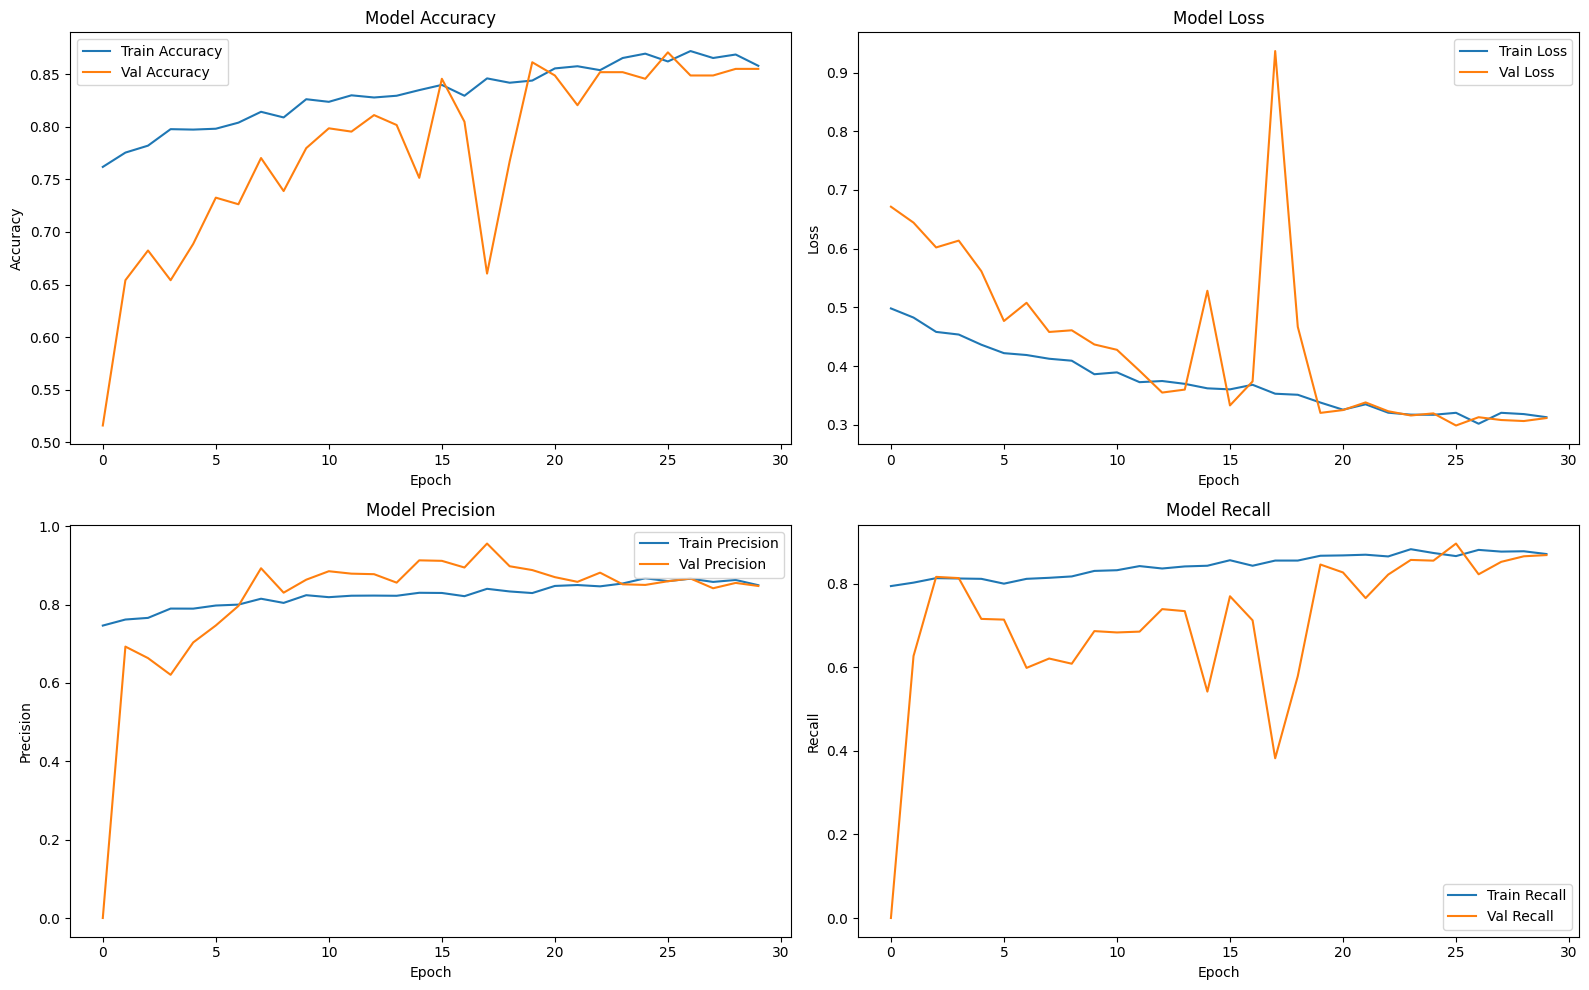

In [ ]:
import os

# 1. Professional Callback Suite
# Innovation: Saving the best model and managing learning dynamics
checkpoint_path = "best_acne_model.keras"

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

# 2. Execute Training
history = model.fit(
    train_ds,
    epochs=30,
    validation_data=validation_ds,
    callbacks=callbacks
)

# 3. Comprehensive Visualization (Engineering Level)
# Plotting Accuracy, Loss, and Medical Metrics (Precision/Recall)
def plot_metrics(history):
    metrics = ['accuracy', 'loss', 'precision', 'recall']
    plt.figure(figsize=(16, 10))

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        plt.plot(history.history[metric], label=f'Train {metric.capitalize()}')
        plt.plot(history.history[f'val_{metric}'], label=f'Val {metric.capitalize()}')
        plt.title(f'Model {metric.capitalize()}')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(history)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
import matplotlib.pyplot as plt
import numpy as np # FIX: Essential for evaluation
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Keep your drive mount and data generators as they were

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
--- Classification Report ---
              precision    recall  f1-score   support

       Clear       0.82      0.83      0.82       155
        Acne       0.83      0.83      0.83       163

    accuracy                           0.83       318
   macro avg       0.83      0.83      0.83       318
weighted avg       0.83      0.83      0.83       318



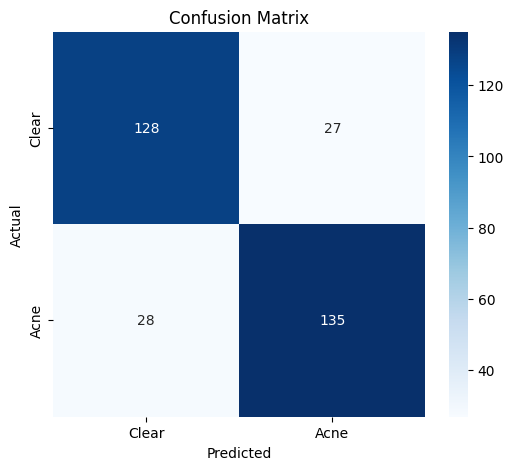

In [ ]:
# 1. Collect true labels and predictions
y_true = []
y_pred_probs = []

# Iterate through validation set to get raw data
for images, labels in validation_ds:
    y_true.extend(labels.numpy())
    probs = model.predict(images)
    y_pred_probs.extend(probs.flatten())

# 2. Convert probabilities to binary classes (0 or 1)
# Because your last layer is 'sigmoid', output is 0.0 to 1.0
y_pred = [1 if p > 0.5 else 0 for p in y_pred_probs]

# 3. Professional Metrics Table
print("--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=['Clear', 'Acne']))

# 4. Confusion Matrix (Visual Error Analysis)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Clear', 'Acne'], yticklabels=['Clear', 'Acne'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

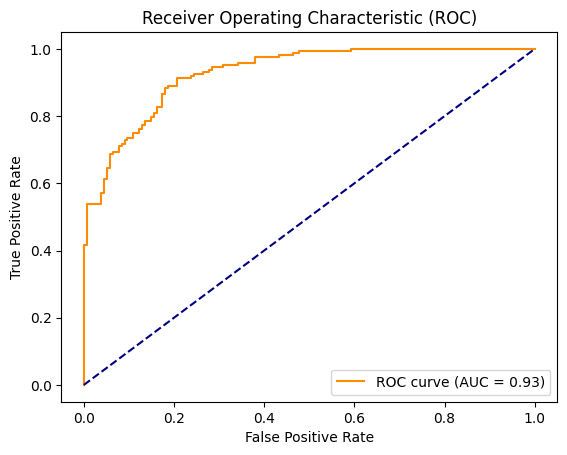

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


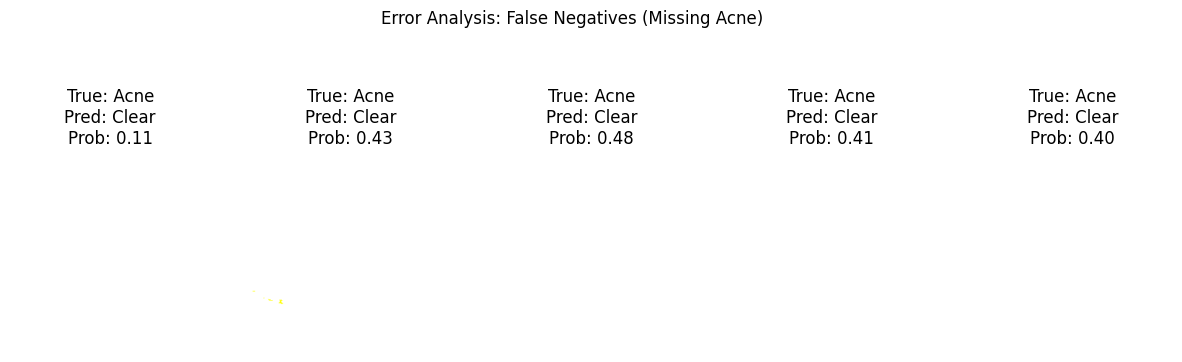

In [ ]:
# Identify the most confident mistakes
y_true = []
y_pred_probs = []
all_images = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())
    probs = model.predict(images)
    y_pred_probs.extend(probs.flatten())
    all_images.extend(images.numpy())

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred = (y_pred_probs > 0.5).astype(int)

# Finding False Negatives (Actual Acne, Predicted Clear)
# These are the most dangerous errors in medical AI.
fn_indices = np.where((y_true == 1) & (y_pred == 0))[0]

plt.figure(figsize=(15, 5))
for i, idx in enumerate(fn_indices[:5]):
    plt.subplot(1, 5, i+1)
    plt.imshow(all_images[idx])
    plt.title(f"True: Acne\nPred: Clear\nProb: {y_pred_probs[idx]:.2f}")
    plt.axis('off')
plt.suptitle("Error Analysis: False Negatives (Missing Acne)")
plt.show()